# Train Gaussian Mixture Regression

In [1]:
using AutomotiveDrivingModels
using RandomForestBehaviors

# Parameters

In [2]:
include(Pkg.dir("AutomotiveDrivingModels", "scripts", "extract_params.jl"))
dset_filepath_modifier = "_following" # _freeflow, _following, _lanechange
dset = JLD.load(joinpath(EVALUATION_DIR, "dataset2" * dset_filepath_modifier * ".jld"),
                "model_training_data")::ModelTrainingData2
runlogs_original = load_runlogs(dset)
streetnets = load_streetnets(runlogs_original)

fold = 1
cv_split_outer = get_fold_assignment_across_drives(dset, N_FOLDS)
cv_split_inner = drop_fold!(deepcopy(cv_split_outer), fold)
@assert(cv_split_inner.nfolds > 0)

ntraces = length(cv_split_outer.seg_assignment);

## Optimize Hyperparams

In [3]:
const INDICATOR_SET_MICRO = [
                    # POSFYAW, SPEED, VELFS, VELFT,
                    # TURNRATE,
                    ACC, #ACCFS, ACCFT,
                    # MARKERDIST_LEFT, MARKERDIST_RIGHT,
                    # ESTIMATEDTIMETOLANECROSSING, A_REQ_STAYINLANE,
                    # HAS_LANE_RIGHT, HAS_LANE_LEFT,

                    # DIST_FRONT, DELTA_V_FRONT, ACC_REQ_FRONT, INV_TTC_FRONT, INV_TIMEGAP_FRONT,
                    # HAS_REAR,  DIST_REAR,  D_Y_REAR,  DELTA_V_REAR,  DELTA_V_Y_REAR,  YAW_REAR,  TURNRATE_REAR,  ACC_REQ_REAR,  INV_TTC_REAR,  INV_TIMEGAP_REAR,  REAR_IS_GAINING,
                    # HAS_LEFT,  DIST_LEFT,  D_Y_LEFT,  DELTA_V_LEFT,  DELTA_V_Y_LEFT,  YAW_LEFT,  TURNRATE_LEFT,  ACC_REQ_LEFT,  INV_TTC_LEFT,  INV_TIMEGAP_LEFT,  LEFT_IS_GAINING,
                    # HAS_RIGHT, DIST_RIGHT, D_Y_RIGHT, DELTA_V_RIGHT, DELTA_V_Y_RIGHT, YAW_RIGHT, TURNRATE_RIGHT, ACC_REQ_RIGHT, INV_TTC_RIGHT, INV_TIMEGAP_RIGHT, RIGHT_IS_GAINING,

                    # Feature_Past{symbol(VELFT), 1}(),  Feature_Past{symbol(VELFT), 2}(),  Feature_Past{symbol(VELFT), 3}(),  Feature_Past{symbol(VELFT), 4}(),
                    # Feature_Past{symbol(POSFT), 1}(),  Feature_Past{symbol(POSFT), 2}(),  Feature_Past{symbol(POSFT), 3}(),  Feature_Past{symbol(POSFT), 4}(),
                    # Feature_Past{symbol(INV_TTC_FRONT), 1}(),  Feature_Past{symbol(INV_TTC_FRONT), 2}(),  Feature_Past{symbol(INV_TTC_FRONT), 3}(),  Feature_Past{symbol(INV_TTC_FRONT), 4}(),
                    # Feature_Past{symbol(ACC), 1}(),    Feature_Past{symbol(ACC), 2}(),    Feature_Past{symbol(ACC), 3}(),    Feature_Past{symbol(ACC), 4}(),
                    Feature_Past{:f_des_angle, 1}(),  # Feature_Past{:f_des_angle, 2}(),   Feature_Past{:f_des_angle, 3}(),   Feature_Past{:f_des_angle, 4}(),

                    # Feature_Mean_Over_History{symbol(ACC),4}(), Feature_Mean_Over_History{symbol(ACC),8}(),
                    # Feature_Mean_Over_History{:f_des_angle,4}(), Feature_Mean_Over_History{:f_des_angle,8}(),

                    # Feature_Std_Over_History{symbol(ACC),4}(), Feature_Std_Over_History{symbol(ACC),8}(),
                    # Feature_Std_Over_History{:f_des_angle,4}(), Feature_Std_Over_History{:f_des_angle,8}(),

                    # Feature_Max_Over_History{symbol(ACC),4}(), Feature_Max_Over_History{symbol(ACC),8}(),
                    # Feature_Max_Over_History{:f_des_angle,4}(), Feature_Max_Over_History{:f_des_angle,8}(),

                    # Feature_Min_Over_History{symbol(ACC),4}(), Feature_Min_Over_History{symbol(ACC),8}(),
                    # Feature_Min_Over_History{:f_des_angle,4}(), Feature_Min_Over_History{:f_des_angle,8}(),
                ]

train_def = BehaviorTrainDefinition(
                                            GMR_TrainParams(indicators=INDICATOR_SET_MICRO, n_gmm_iter=20, n_init=1, min_covar=1e-7),
                                            [
                                                BehaviorParameter(:n_components, [3,5,10], 2),
                                                # BehaviorParameter(:tol, [0.1, 0.15, 0.2], 2),
                                                # BehaviorParameter(:min_covar, [1e-7,1e-6,1e-5,1e-4], 2),
                                                BehaviorParameter(:max_n_indicators, [3,4,5], 2),
                                                BehaviorParameter(:unlearned_component_weight, [0.01,0.05,0.1], 2)
                                                # BehaviorParameter(:use_PCA, [false, true], 1),
                                            ])

preallocated_data = preallocate_learning_data(dset, train_def.trainparams)
print(train_def); sleep(0.1)

BehaviorTrainDefinition
GMR Train Params
	targets: (:f_des_angle,:f_accel)
	indicators: [:acc,:past_1_f_des_angle]
	n_components:     2
	max_n_indicators: 3
	use_PCA:   false
	min_covar:        1.0e-7

hyperparams:
	n_components:        [3, >5<, 10]
	max_n_indicators:    [3, >4<, 5]
	unlearned_component_weight: [0.01, >0.05<, 0.1]


In [4]:
# AutomotiveDrivingModels.optimize_hyperparams_cyclic_coordinate_ascent!(
#                     train_def, dset, preallocated_data, cv_split_inner)
# print(train_def); sleep(0.1)

## Train

In [5]:
GM = train(dset, preallocated_data, train_def.trainparams, FoldSet(cv_split_outer, fold, false, :frame));
print(GM)
sleep(0.1)

best score: 77606.764644
best score: 141635.910855
best score: 170558.374146
Gaussian Mixture Regression Model
	targets: (:f_des_angle,:f_accel)
	ncomponents: 2
	nindicators: 2
GMR:
1
	[   -0.003204    0.002374] + [    0.010753]
	[   -0.279744    0.000948] + [   -0.015419]
2
	[   -0.000018    0.013104] + [    0.001023]
	[   -0.283899   -0.000765] + [   -0.011394]
	mixture_Obs: 
		prior: Distributions.Categorical(K=2, p=[0.01629518638968526,0.9837048136103153])


## Likelihood

In [8]:
arr_logl_train = Float64[]
arr_logl_test = Float64[]
for frameind in 1 : nrow(dset.dataframe)
    if trains_with_nona(GM)
        logl = calc_action_loglikelihood(GM, dset.dataframe_nona, frameind)
    else
        logl = calc_action_loglikelihood(GM, dset.dataframe, frameind)
    end
    
    if is_in_fold(fold, cv_split_outer.frame_assignment[frameind], true)
        push!(arr_logl_test, logl)
    else
        push!(arr_logl_train, logl)
    end
end

@printf("%10s  %10s  %10s  %10s\n", "min", "mean", "median", "max")
@printf("%10.4f  %10.4f  %10.4f  %10.4f\n", minimum(arr_logl_train), mean(arr_logl_train), median(arr_logl_train), maximum(arr_logl_train))
@printf("%10.4f  %10.4f  %10.4f  %10.4f\n", minimum(arr_logl_test), mean(arr_logl_test), median(arr_logl_test), maximum(arr_logl_test))

       min        mean      median         max
  -52.8621      6.3861      7.0842      7.8332
  -13.8937      6.2939      6.8230      7.8331


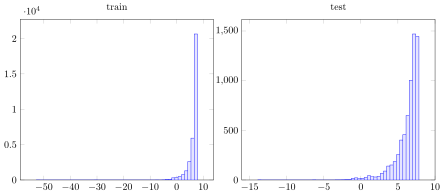

In [10]:
using PGFPlots
g = GroupPlot(2,1)
push!(g, Axis(Plots.Histogram(arr_logl_train, bins=50), ymin=0, title="train"))
push!(g, Axis(Plots.Histogram(arr_logl_test, bins=50), ymin=0, title="test"))
g

ninliers:   7967 (99.35 percent)
noutliers:    52 ( 0.65 percent)
mean logl:     1.653290
median logl:   1.742506


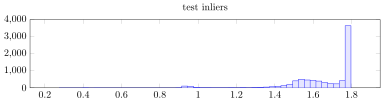

In [10]:
# Given:
#    data - a set of observed data points
#    model - a model that can be fitted to data points
#    n - the minimum number of data values required to fit the model
#    k - the maximum number of iterations allowed in the algorithm
#    t - a threshold value for determining when a data point fits a model
#    d - the number of close data values required to assert that a model fits well to data
# Return:
#    bestfit - model parameters which best fit the data (or nil if no good model is found)

using Distributions

data = arr_logl_test
m = length(data)
model = Normal
n = 10
k = 10
t = -4 # log likelihood
d = m*0.6 # 90% of the dataset
        
iterations = 0
bestfit = NaN
bestninliers = 0
besterr = Inf
bestdata = Float64[]
best_median_logl = NaN
while iterations < k
    
    maybeinliers = randperm(m)[1:n] # n randomly selected values from data
    maybemodel = fit_mle(model, data[maybeinliers]) # model parameters fitted to maybeinliers
    alsoinliers = Int[] # empty set
    
    for (i,v) in enumerate(data)
        if !in(i, maybeinliers)
            if logpdf(maybemodel, v) > t # point fits maybemodel with an error smaller than t
                push!(alsoinliers, i) # add point to alsoinliers
            end
        end
    end

    
    if length(alsoinliers) > d
        # this implies that we may have found a good model
        # now test how good it is
        fitdata = data[[maybeinliers; alsoinliers]]
        bettermodel = fit_mle(model, fitdata) # model parameters fitted to all points in maybeinliers and alsoinliers
        thiserr = sum(v->logpdf(bettermodel, v), fitdata)/length(fitdata) # a measure of how well model fits these points
        
        if thiserr < besterr
            bestfit = bettermodel
            besterr = thiserr
            bestninliers = length(fitdata)
            best_median_logl = median(fitdata)
            bestdata = fitdata
        end
    end
    iterations += 1
end
@printf("ninliers:  %5d (%5.2f percent)\n", bestninliers, 100*bestninliers/m)
@printf("noutliers: %5d (%5.2f percent)\n", m-bestninliers, 100*(1.0-bestninliers/m))
@printf("mean logl:   %10.6f\n", mean(bestfit))
@printf("median logl: %10.6f\n", best_median_logl)

Axis(Plots.Histogram(bestdata, bins=50), ymin=0, title="test inliers", width="14cm", height="4cm")